In [65]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels

os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [67]:
def distance(lat1, lat2, lon1, lon2):
    # convert from degrees to radians
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return (c * r) * 1000  # results in M

def get_row_length(df_jz):
    try:
        if isinstance(df_jz, str):
            df_jz = pd.read_csv(df_jz)
        df_merged = df_jz
        df_merged = df_merged.fillna(method='bfill')

        if df_merged is None: # None where is no overlap between GPS and JZ
            return 0
        first_index = min(df_merged.index)
        last_index = max(df_merged.index)
        lat1 = float(df_merged.latitude[first_index])
        lat2 = float(df_merged.latitude[last_index])
        lon1 = float(df_merged.longitude[first_index])
        lon2 = float(df_merged.longitude[last_index])

        return distance(lat1, lat2, lon1, lon2)
    except:
        return 0


def get_valid_row_paths(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["jaized_timestamps.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "jaized_timestamps.csv"))
    return paths_list

def get_full_name_from_path(path_to_row_jz):
    customer_name = os.path.basename(go_up_n_levels(path_to_row_jz,5))
    block_name = os.path.basename(go_up_n_levels(path_to_row_jz,4))
    row_name = "R" + os.path.basename(go_up_n_levels(path_to_row_jz,2)).split("_")[-1]
    scan_name = "S" + os.path.basename(go_up_n_levels(path_to_row_jz,1)).split("_")[-1]
    full_name = f"{customer_name}_{block_name}_{row_name}_{scan_name}"
    return full_name

def run_on_folder(master_folder, njobs=1):
    paths_list = get_valid_row_paths(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_row_length, paths_list))
    else:
        res = list(map(get_row_length, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
master_folder = "/media/fruitspec-lab/cam175/FOWLER"
row_lengths = run_on_folder(master_folder)


row_lengths

{'FOWLER_BLOCKAT0_R10_S1': 383.93036172078627,
 'FOWLER_BLOCKAT0_R11_S1': 368.5805847745104,
 'FOWLER_BLOCKAT0_R12_S1': 384.93463295742293,
 'FOWLER_BLOCKAT0_R13_S1': 385.0239814500981,
 'FOWLER_BLOCKAT0_R14_S1': 385.2761415943326,
 'FOWLER_BLOCKAT0_R15_S1': 385.38666025177037,
 'FOWLER_BLOCKAT0_R4_S1': 0,
 'FOWLER_BLOCKAT0_R5_S1': 376.32606691804114,
 'FOWLER_BLOCKAT0_R6_S1': 383.3665475837488,
 'FOWLER_BLOCKAT0_R7_S1': 385.4837590410341,
 'FOWLER_BLOCKAT0_R8_S1': 383.74820046342796,
 'FOWLER_BLOCKAT0_R9_S1': 384.2066547088208,
 'FOWLER_BLOCKAX0_R1_S1': 382.5724465082087,
 'FOWLER_BLOCKAX0_R10_S1': 379.7954542691559,
 'FOWLER_BLOCKAX0_R11_S1': 0,
 'FOWLER_BLOCKAX0_R12_S1': 367.8815101790299,
 'FOWLER_BLOCKAX0_R13_S1': 0,
 'FOWLER_BLOCKAX0_R14_S1': 282.3153347617575,
 'FOWLER_BLOCKAX0_R15_S1': 44.08832976491938,
 'FOWLER_BLOCKAX0_R2_S1': 0,
 'FOWLER_BLOCKAX0_R4_S1': 380.38084233482704,
 'FOWLER_BLOCKAX0_R5_S1': 382.35401441635497,
 'FOWLER_BLOCKAX0_R6_S1': 0,
 'FOWLER_BLOCKAX0_R7_S1': 

In [68]:
def get_valid_row_paths_n_tracks(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["tracks.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "tracks.csv"))
    return paths_list

def get_n_tracks(tracks_path):
    df_tracks = pd.read_csv(tracks_path)
    uniq, counts = np.unique(df_tracks["track_id"], return_counts=True)
    return len(uniq), len(uniq[counts>1]), len(uniq[counts>2])

def run_on_folder_tracks(master_folder, njobs=1):
    paths_list = get_valid_row_paths_n_tracks(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_n_tracks, paths_list))
    else:
        res = list(map(get_n_tracks, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
master_folder = "/media/fruitspec-lab/cam175/FOWLER"
n_tracks = run_on_folder_tracks(master_folder)


n_tracks

{'FOWLER_BLOCKAT0_R10_S1': (92476, 66240, 54389),
 'FOWLER_BLOCKAT0_R11_S1': (109091, 79816, 65738),
 'FOWLER_BLOCKAT0_R12_S1': (75296, 53445, 44082),
 'FOWLER_BLOCKAT0_R13_S1': (92911, 65888, 53473),
 'FOWLER_BLOCKAT0_R14_S1': (69177, 47779, 38930),
 'FOWLER_BLOCKAT0_R15_S1': (93630, 65093, 52129),
 'FOWLER_BLOCKAT0_R4_S1': (72925, 53252, 44602),
 'FOWLER_BLOCKAT0_R6_S1': (81018, 59218, 49868),
 'FOWLER_BLOCKAT0_R7_S1': (93530, 68773, 56906),
 'FOWLER_BLOCKAT0_R8_S1': (84392, 61019, 50955),
 'FOWLER_BLOCKAT0_R9_S1': (107569, 79296, 65946),
 'FOWLER_BLOCKAX0_R1_S1': (30743, 20740, 17374),
 'FOWLER_BLOCKAX0_R10_S1': (20406, 13254, 10841),
 'FOWLER_BLOCKAX0_R11_S1': (27277, 19169, 16306),
 'FOWLER_BLOCKAX0_R12_S1': (22619, 15224, 12472),
 'FOWLER_BLOCKAX0_R14_S1': (12662, 8478, 7004),
 'FOWLER_BLOCKAX0_R15_S1': (1915, 1355, 1121),
 'FOWLER_BLOCKAX0_R4_S1': (25211, 16938, 14198),
 'FOWLER_BLOCKAX0_R5_S1': (26655, 17504, 14281),
 'FOWLER_BLOCKAX0_R7_S1': (2, 0, 0),
 'FOWLER_BLOCKAX0_R8_S1'

In [69]:
df_out = pd.DataFrame(n_tracks).T
df_out.columns = ["cv1", "cv2", "cv3"]
df_out["row_len"] = df_out.index.map(row_lengths)
for i in range(1,4):
    df_out[f"cv{i}_per_meter"] = df_out[f"cv{i}"]/df_out["row_len"]
df_out = df_out[df_out["row_len"] > 100]
df_out

,cv1,cv2,cv3,row_len,cv1_per_meter,cv2_per_meter,cv3_per_meter
FOWLER_BLOCKAT0_R10_S1,92476,66240,54389,383.930362,240.866598,172.531288,141.663712
FOWLER_BLOCKAT0_R11_S1,109091,79816,65738,368.580585,295.975981,216.549659,178.354484
FOWLER_BLOCKAT0_R12_S1,75296,53445,44082,384.934633,195.607237,138.841755,114.518145
FOWLER_BLOCKAT0_R13_S1,92911,65888,53473,385.023981,241.312242,171.127003,138.882258
FOWLER_BLOCKAT0_R14_S1,69177,47779,38930,385.276142,179.551736,124.012351,101.044409
FOWLER_BLOCKAT0_R15_S1,93630,65093,52129,385.386660,242.950807,168.903096,135.264153
FOWLER_BLOCKAT0_R6_S1,81018,59218,49868,383.366548,211.332993,154.468355,130.079164
FOWLER_BLOCKAT0_R7_S1,93530,68773,56906,385.483759,242.630196,178.406997,147.622302
FOWLER_BLOCKAT0_R8_S1,84392,61019,50955,383.748200,219.915038,159.007912,132.782382
FOWLER_BLOCKAT0_R9_S1,107569,79296,65946,384.206655,279.976931,206.388929,171.642004


In [70]:
df_out.to_csv("/home/fruitspec-lab/Downloads/cv_res.csv")

In [71]:
planting_dist = {"BLOCKAT0": 3.048, "BLOCKAX0":3.048, 'BLOCKBT0':3.048, "G60CLEM0": 3.3528, "MOVSESI0": 3.048}

In [72]:
tangos = ["BLOCKAT0", "BLOCKBT0", "MOVSESI0"]
clem = ["BLOCKAX0", "G60CLEM0"]

In [73]:
df_out["block"] = [ind.split("_")[1] for ind in df_out.index]
df_out["plant_dist"] = df_out["block"].map(planting_dist)
df_out["ntrees"] = df_out["row_len"]/df_out["plant_dist"]
for i in range(1,4):
    df_out[f"cv{i}_per_tree"] = df_out[f"cv{i}"]/df_out["ntrees"]
df_out.groupby("block").median().round(2).to_csv("/home/fruitspec-lab/Downloads/res.csv")
df_out.groupby("block").median().round(2)

,cv1,cv2,cv3,row_len,cv1_per_meter,cv2_per_meter,cv3_per_meter,plant_dist,ntrees,cv1_per_tree,cv2_per_tree,cv3_per_tree
block,,,,,,,,,,,,
BLOCKAT0,92693.5,65490.5,52801.0,384.57,241.09,170.02,137.07,3.05,126.17,734.84,518.21,417.80
BLOCKAX0,23915.0,16081.0,13335.0,380.09,63.88,42.96,35.61,3.05,124.70,194.71,130.93,108.55
BLOCKBT0,83797.5,53860.0,40811.0,390.12,233.90,152.74,115.93,3.05,127.99,712.94,465.54,353.35
G60CLEM0,18307.0,13157.0,11359.0,369.88,49.65,35.68,30.81,3.35,110.32,166.46,119.64,103.29
MOVSESI0,92944.0,67922.0,57443.0,387.83,239.23,176.36,149.16,3.05,127.24,729.17,537.56,454.62


# F_modeling

### Load data

In [27]:
use_best_study = True
features_path = "/media/fruitspec-lab/cam175/FOWLER/features_FOWLER_3rd_scan.csv"
cfg = OmegaConf.load("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/model_config.yaml")
final_cols, drop_final = get_rel_cols(cfg)
f_df = read_f_df(cfg)
features_df = pd.read_csv(features_path)
f_df = f_df[f_df["customer_name"] == "FOWLER"]

In [28]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

In [29]:
# merge F on name
df_f_org = features_df
df_f_org["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))

In [30]:
df_f_org[[f"cv{i}" for i in range(1,6)] + 
         ["F", "name", "block_name"]].to_csv("/media/fruitspec-lab/cam175/FOWLER/features_FOWLER_3rd_scan_w_f.csv")


In [31]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_f_org[cv_F_col] = df_f_org[cv_col]/df_f_org["F"]

In [ ]:
# df_f_org.to_csv(f"{df_f_path.split('.')[0]}_cvf.csv")

### Short EDA

In [32]:
df_f_org[cv_F_cols].mean()

cv1/F    0.215341
cv2/F    0.160827
cv3/F    0.136900
cv4/F    0.117530
cv5/F    0.103069
dtype: float64

In [33]:
df_f_org.groupby(["block_name"])[cv_F_cols].mean()

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BLOCKAT0,0.333577,0.250587,0.212894,0.180922,0.155209
G60CLEM0,0.132576,0.097995,0.083704,0.073156,0.066571


In [42]:
df_f = df_f_org.copy()

### CV-F graphs

In [43]:
def plot_F_cv(df,min_samp = "", hue = None, title= "", col = ""):
    if col == "":
        col = f"cv{min_samp}"
    max_val = np.min(np.max(df[[col, "F"]].values, axis = 0))
    ax = sns.lmplot(data = df, x = col, y="F", hue = hue)
    sns.regplot(data = df, x = col, y="F", scatter_kws={'s':2}, order = 1,ci=0, ax=ax.axes[0,0],
               x_ci = 0, color = "black", line_kws={"ls":"--"},scatter=False)
    plt.plot([0, max_val], [0, max_val], color='grey')
    plt.ylim(0, np.max(df["F"]*1.1))
    plt.title(title)
    plt.show()

<Figure size 1000x600 with 0 Axes>

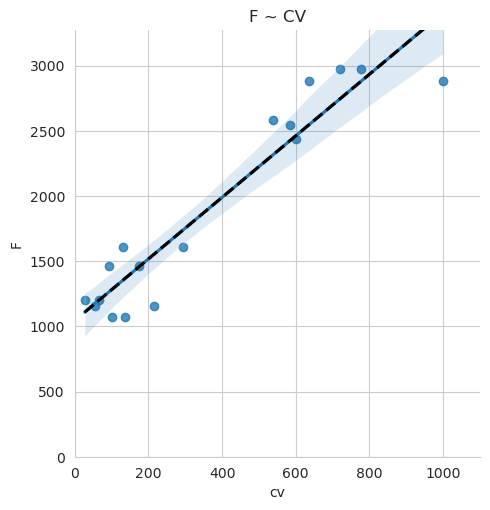

In [44]:

df = df_f_org.copy()
col = 'cv2'
max_val = np.min(np.max(df[[col, "F"]].values, axis=0))

plt.figure(figsize=(10, 6))  # Adjust figure size

# Enable grid lines
sns.set_style("whitegrid")

ax = sns.lmplot(data=df, x=col, y="F", palette="Blues")  # Customize color palette
sns.regplot(data=df, x=col, y="F", scatter_kws={'s': 5}, order=1, ci=0, ax=ax.axes[0, 0],
            x_ci=0, color="black", line_kws={"ls": "--"},scatter=False)  # Adjust scatter marker size and line style

plt.xlim(0, np.max(df[col] * 1.1))  # Adjust x-axis limits
plt.ylim(0, np.max(df["F"] * 1.1))  # Adjust y-axis limits

plt.xlabel("cv")  # Set x-axis label
plt.ylabel("F")  # Set y-axis label
plt.title("F ~ CV")  # Set plot title

plt.show()

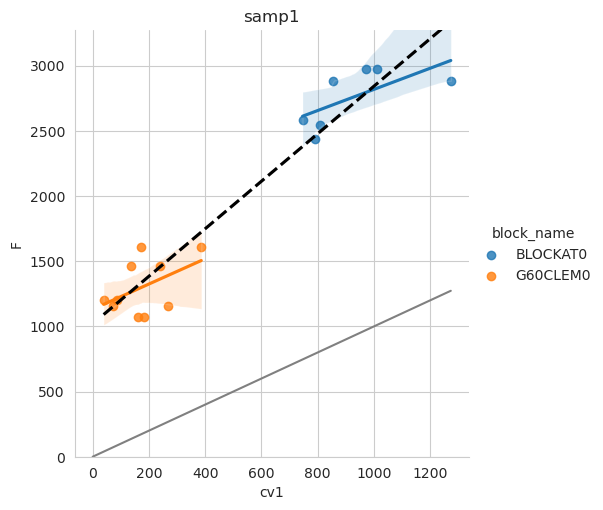

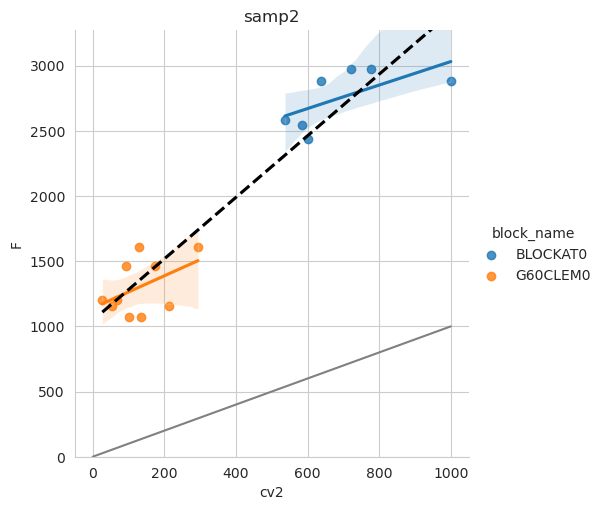

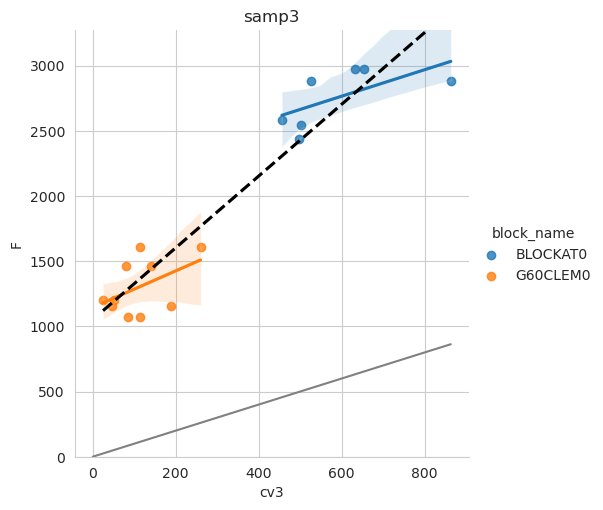

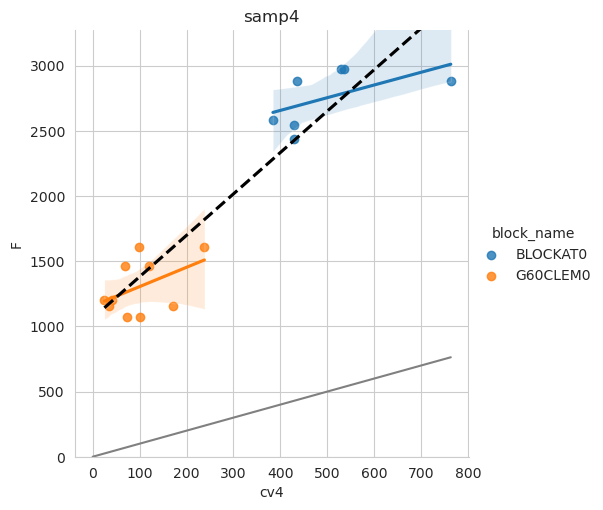

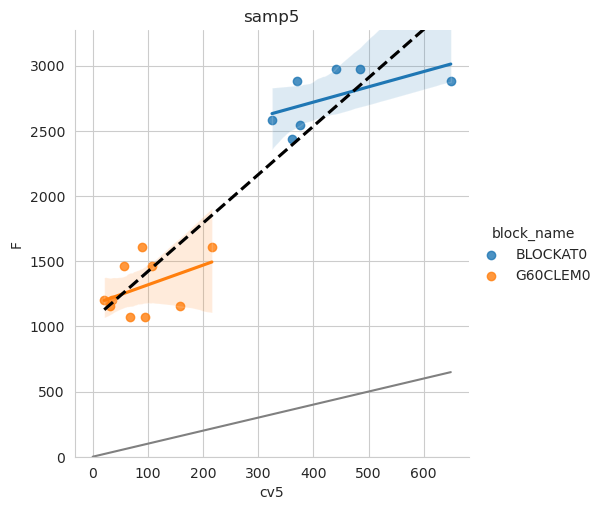

In [45]:
for i in range(1,6):
    plot_F_cv(df_f,i,"block_name", f"samp{i}")

### Exporing new features

In [20]:
df_f["cv1/cv2"] = df_f["cv1"]/df_f["cv2"]
df_f["cv2/cv3"] = df_f["cv2"]/df_f["cv3"]
df_f["cv1/cv3"] = df_f["cv1"]/df_f["cv3"]
df_f["percent_hidden1"] = (df_f["F"]-df_f["cv1"])/df_f["F"]
df_f["percent_hidden2"] = (df_f["F"]-df_f["cv2"])/df_f["F"]
df_f["percent_hidden3"] = (df_f["F"]-df_f["cv3"])/df_f["F"]

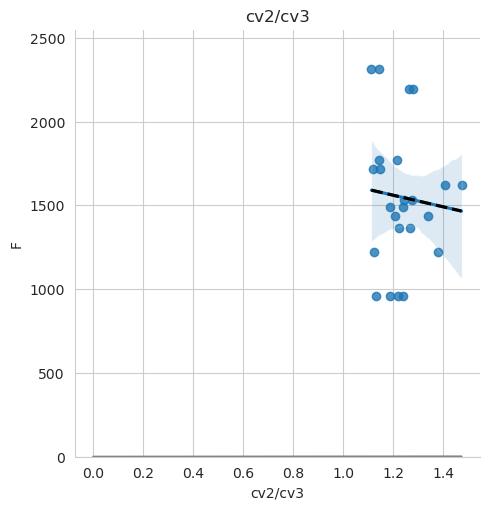

In [21]:
plot_F_cv(df_f, title= "cv2/cv3", col = "cv2/cv3")

### Modeling

In [46]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

from MHS.scoring import cross_validate_with_mean
from sklearn.linear_model import LinearRegression, PoissonRegressor

class MaxLinearRegressor(LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
    
    def predict(self, X):
        predicted_values = super().predict(X)
        return np.array([max(p, 0) for p in predicted_values])

In [48]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: row{x["name"].split("_")[1]}', axis = 1)
#filter
# df = df[df["speed"] == 4].reset_index()

groups = df["block_name"]

  
X = df[["cv2"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor(fit_intercept = False)
cross_validate_with_mean(model, X, y, groups=groups)

true: 13004.0,    pred: 4970.7816905072405. (61.77 %) (G60CLEM0)
true: 19286.0,    pred: 37742.519137399424. (95.70 %) (BLOCKAT0)
0.7858069304897052 0.1622466177523516


(0.7873701557387799, 0.16962036263721425)

In [62]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = True)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 4229.0,    pred: 3535.7664077563654. (16.39 %) (G60CLEM0: R5)
true: 4229.0,    pred: 4815.678906562682. (13.87 %) (G60CLEM0: R4)
true: 7570.0,    pred: 7250.319949311165. (4.22 %) (BLOCKAT0: R4)
true: 2273.0,    pred: 2435.287503013842. (7.14 %) (G60CLEM0: R12)
true: 2273.0,    pred: 2600.379475461885. (14.40 %) (G60CLEM0: R11)
true: 5858.0,    pred: 6561.4847583800265. (12.01 %) (BLOCKAT0: R7)
true: 5858.0,    pred: 5198.733163509758. (11.25 %) (BLOCKAT0: R6)
0.12793731222813673 0.039018294937118086
(0.11327709703313242, 0.039653964931945423)
true: 13004.0,    pred: 21485.832662110693. (65.22 %) (G60CLEM0)
true: 19286.0,    pred: 14173.066792733309. (26.51 %) (BLOCKAT0)
0.47517711027755016 0.21133688422031663
(0.45867955112552516, 0.19356842350617998)
1019.7761725854415 [1.82296782]


In [63]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv1"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept = False)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.coef_)

true: 7570.0,    pred: 6542.882012288604. (13.57 %) (BLOCKAT0: R4)
true: 5858.0,    pred: 7327.913381340928. (25.09 %) (BLOCKAT0: R7)
true: 5858.0,    pred: 5134.667692218385. (12.35 %) (BLOCKAT0: R6)
0.17085602953906975 0.05864252783645226
(0.17002816126284048, 0.05741866872745411)
[2.91702571]
true: 4229.0,    pred: 1978.142308356354. (53.22 %) (G60CLEM0: R5)
true: 4229.0,    pred: 7894.046750536074. (86.66 %) (G60CLEM0: R4)
true: 2273.0,    pred: 1148.1207534647974. (49.49 %) (G60CLEM0: R12)
true: 2273.0,    pred: 1559.7771528861365. (31.38 %) (G60CLEM0: R11)
0.5475870585198075 0.2073411307551607
(0.5518893894054077, 0.19962647357143082)
[5.89521575]


In [64]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv1"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept=True)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.intercept_, model.coef_)

true: 7570.0,    pred: 8840.406442065409. (16.78 %) (BLOCKAT0: R4)
true: 5858.0,    pred: 6759.119532581351. (15.38 %) (BLOCKAT0: R7)
true: 5858.0,    pred: 5349.45047256018. (8.68 %) (BLOCKAT0: R6)
0.13703198945561793 0.03586453405889803
(0.13615372807387813, 0.035353941506307975)
2006.8390374077817 [0.81135792]
true: 4229.0,    pred: 3528.554864792371. (16.56 %) (G60CLEM0: R5)
true: 4229.0,    pred: 4148.149746464246. (1.91 %) (G60CLEM0: R4)
true: 2273.0,    pred: 2507.159518822312. (10.30 %) (G60CLEM0: R12)
true: 2273.0,    pred: 2590.8542992005505. (13.98 %) (G60CLEM0: R11)
0.13304621447718853 0.017533425824768696
(0.10690100353092728, 0.05535075489514646)
1131.1359674589614 [0.96888399]


In [ ]:
model.int

In [ ]:
tangos = ["OLIVER55", "BLOCK700"]
clem = ["BLAYNEY0", "FREDIANI", "MAZMANI2"]

# Tango

In [ ]:
df = df_f[df_f["block_name"].isin(tangos)].reset_index(drop = True).copy()
plot_F_cv(df,1,"block_name", f"samp{1}")
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
model.coef_

# clem

In [ ]:
df = df_f[df_f["block_name"].isin(clem)].reset_index(drop = True).copy()
plot_F_cv(df,1,"block_name", f"samp{1}")
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
model.coef_

## V -shape

In [ ]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df = df[~df["F_V"].isna()]
#filter
df = df[df["depth_filter"] == 5].reset_index(drop = True)
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]

  
X = df[["cv3"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F_V"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)

In [ ]:
cv_cols = [f"cv{i}" for i in range(1,4)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df[cv_F_col] = df[cv_col]/df["F"]

    display(df.groupby("speed")[cv_F_cols].mean())
display(df.groupby(["speed", "block"])[cv_F_cols].mean())
display(df.groupby("side")[cv_F_cols].mean())

In [ ]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df = df[~df["F_V"].isna()]#filter
df = df[df["depth_filter"] == 5].reset_index()
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]
  
X = df[["cv2"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F_V"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=None, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=None)

In [ ]:
cv_cols = [f"cv{i}" for i in range(1,4)]
cv_F_cols = [f"{col}/F_V" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df[cv_F_col] = df[cv_col]/df["F_V"]

display(df[cv_F_cols].mean())
display(df.groupby("speed")[cv_F_cols].mean())
display(df.groupby(["speed", "block"])[cv_F_cols].mean())
display(df.groupby("side")[cv_F_cols].mean())

## combining A+B results

need to map section to block

In [ ]:
df_comb = df_f_org.groupby(["section", "speed"]).mean()
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_comb[cv_F_col] = df_comb[cv_col]/df_comb["F"]
df_comb

In [ ]:
sections = [i[0] for i in df_comb.index]

In [ ]:
def sec_to_block(section):
    if section<=5:
        return "HC-2"
    if section<=10 or (section>=25 and section<=29):
        return "GL-2"
    if section<=15:
        return "HC-1"
    return "GL-1"
blocks = [sec_to_block(sec) for sec in sections]
df_comb["block"] = blocks

In [ ]:
df = df_comb.reset_index()
#filter
# df = df[df["speed"] == 4].reset_index()
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]

  
X = df[["cv2", "cv3"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)